In [1]:
import xupy as xp
import matplotlib.pyplot as plt
from numpy.ma import masked_array

from ekarus.e2e.utils.image_utils import reshape_on_mask, image_grid, get_circular_mask
from ekarus.e2e.devices.pyramid_wfs import PyramidWFS
from ekarus.e2e.devices.detector import Detector
from ekarus.e2e.devices.slope_computer import SlopeComputer


[XuPy] Device 0 available - GPU : `NVIDIA GeForce RTX 4060 Laptop GPU`
       Memory = 7805.56 MB | Compute Capability = 8.9
       Using CuPy 13.5.1 for acceleration.


In [ ]:
def mask_with_spiders(mask, spiderWidth, spiderAngles, maskCenter=None, min_island_size:int=100):
    """
    Adds radial spiders to mask.

    Parameters
    ----------
    spiderWidth : array
        The spiders' width in pixels.
    spiderAngles : array
        Spiders' orientation angle, CCW from East.
    """
    cmask = mask.copy()
    if maskCenter is not None:
        cx,cy = maskCenter
    else:
        cx,cy = mask.shape[0]/2,mask.shape[1]/2 #mask.shape[0]//2-0.5,mask.shape[1]//2-0.5
    for angle in spiderAngles:
        cos_a = xp.cos(angle)
        sin_a = xp.sin(angle)
        dist = lambda x,y: xp.abs((xp.asarray(y-cy))*cos_a - (xp.asarray(x-cx))*sin_a)
        # Component along the spider direction (only keep pixels outward from center)
        along = lambda x,y: (xp.asarray(x-cx))*cos_a + (xp.asarray(y-cy))*sin_a
        spider_mask = xp.fromfunction(lambda j,i: (dist(i,j)<spiderWidth) & (along(i,j)>=0), mask.shape)
        cmask = xp.logical_or(cmask, spider_mask.astype(bool))

    # Identify the image petals: contiguous islands where mask == 0 (i.e. cmask == False)
    valid = ~cmask
    # use NumPy via xp.np for labeling
    valid_np = xp.asnumpy(valid).astype(bool)
    h, w = valid_np.shape
    petal_ids_np = xp.np.full((h, w), -1, dtype=int)
    cur_id = 0
    for r in range(h):
        for c in range(w):
            if valid_np[r, c] and petal_ids_np[r, c] == -1:
                stack = [(r, c)]
                petal_ids_np[r, c] = cur_id
                while stack:
                    rr, cc = stack.pop()
                    for dr, dc in ((1, 0), (-1, 0), (0, 1), (0, -1)):
                        nr, nc = rr + dr, cc + dc
                        if 0 <= nr < h and 0 <= nc < w and valid_np[nr, nc] and petal_ids_np[nr, nc] == -1:
                            petal_ids_np[nr, nc] = cur_id
                            stack.append((nr, nc))
                if xp.sum(petal_ids_np == cur_id) >= min_island_size:
                    cur_id += 1
    petal_ids = xp.asarray(petal_ids_np)
    return cmask, petal_ids

In [3]:
Npix = 128
lambdaInM = 750e-9
pupilSizeInM = 8.0
oversampling = 4

cmask = get_circular_mask((Npix,Npix),mask_radius=Npix//2,mask_center=(Npix//2-0.5,Npix//2-0.5))

# Pyramid WFS
lambdaOverD = lambdaInM/pupilSizeInM
apex_angle = 112*(2*xp.pi)*lambdaOverD
wfs = PyramidWFS(apex_angle, oversampling, sensorLambda=lambdaInM)
wfs.set_modulation_angle(modulationAngleInLambdaOverD=3)

# Detector
detector_shape = (256,256)
ccd = Detector(detector_shape=detector_shape)

# Slope computer
pars = {'modulationInLambdaOverD':3}
sc = SlopeComputer(wfs, ccd, pars)
sc.calibrate_sensor(tn='', prefix_str='', recompute=True, zero_phase=(1-cmask), lambdaOverD=lambdaOverD, Npix=64, centerObscurationInPixels=0.0)

Modulating 3 [lambda/D] with 20 modulation steps
Defining the detector subaperture masks ...
Modulating 10 [lambda/D] with 68 modulation steps


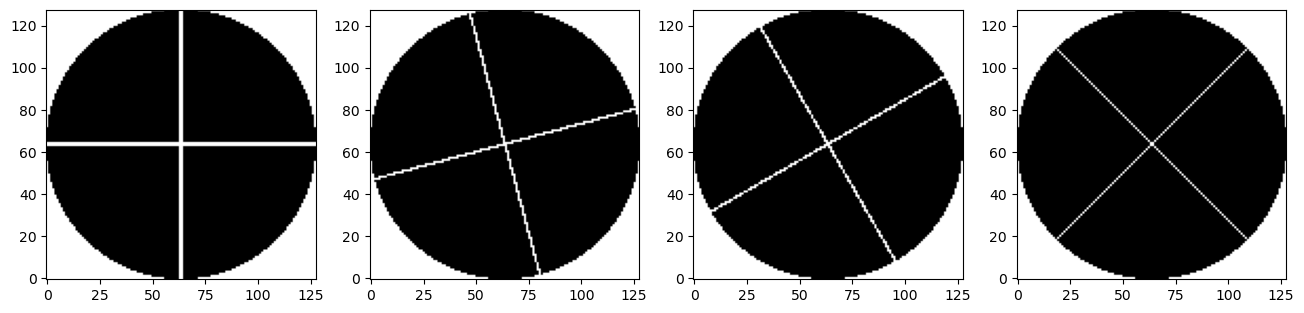

In [4]:
# 4 spiders
m2pix = Npix/pupilSizeInM
deg2rad = xp.pi/180
anglesInDeg = xp.array([0.,90.,180.,270.])
widthInM = 0.6/m2pix

aperture00, petals00 = mask_with_spiders(cmask, widthInM*m2pix, anglesInDeg*deg2rad)
aperture15, petals15 = mask_with_spiders(cmask, widthInM*m2pix, (anglesInDeg+15.)*deg2rad)
aperture30, petals30 = mask_with_spiders(cmask, widthInM*m2pix, (anglesInDeg+30.)*deg2rad)
aperture45, petals45 = mask_with_spiders(cmask, widthInM*m2pix, (anglesInDeg+45.)*deg2rad)

plt.figure(figsize=(16,3.5))
plt.subplot(1,4,1)
plt.imshow(xp.asnumpy(aperture00),origin='lower',cmap='gray')
plt.subplot(1,4,2)
plt.imshow(xp.asnumpy(aperture15),origin='lower',cmap='gray')
plt.subplot(1,4,3)
plt.imshow(xp.asnumpy(aperture30),origin='lower',cmap='gray')
plt.subplot(1,4,4)
plt.imshow(xp.asnumpy(aperture45),origin='lower',cmap='gray')

(128, 128) (128, 128) (128, 128) (128, 128)


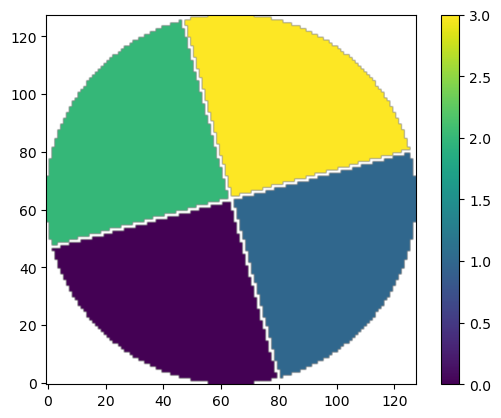

In [5]:
print(petals45.shape,petals00.shape,petals30.shape,petals15.shape)

plt.figure()
plt.imshow(masked_array(xp.asnumpy(petals15),mask=xp.asnumpy(aperture15)),origin='lower')
plt.colorbar()

In [6]:
def calibrate_petal_im(petal_ids, amp:float, method:str='slopes'):    
    Npetals = int(xp.max(petal_ids) + 1)
    field_amp = petal_ids >= 0.0    
    match method:
        case 'slopes':
            Ns = 2
        case 'diagonal_slopes':
            Ns = 3
        case 'raw_intensity':
            Ns = 4
    sc._slope_method = method
    slope_len = int(xp.sum(1-sc._roi_masks[0])*Ns)
    IM = xp.zeros((slope_len,Npetals))
    for p in range(Npetals):
        petal = (petal_ids == p).astype(bool)
        dpiston = xp.zeros(petal_ids.shape)
        dpiston[petal] = 1.0
        dpiston *= amp/xp.std(dpiston)
        field = field_amp * xp.exp(1j*dpiston, dtype=xp.cfloat)
        push_slopes = sc.compute_slopes(field, lambdaOverD, nPhotons=None)
        pull_slopes = sc.compute_slopes(xp.conj(field), lambdaOverD, nPhotons=None)
        IM[:,p] = (push_slopes-pull_slopes)/(2*amp)
    return IM

def get_petal_sensitivity(petal_ids, Rec, amp:float):
    Npetals = int(xp.max(petal_ids) + 1)
    amp_vec = xp.linspace(-amp,amp,27,endpoint=True)
    field_amp = petal_ids >= 0.0
    meas_amps = xp.zeros([Npetals,len(amp_vec)])
    for p in range(Npetals):
        petal = (petal_ids == p).astype(bool)
        dpiston = xp.zeros(petal_ids.shape)
        field = field_amp * xp.exp(1j*dpiston, dtype=xp.cfloat)
        slope_null = sc.compute_slopes(field, lambdaOverD, nPhotons=None)
        for k,amp in enumerate(amp_vec):
            dpiston = xp.zeros(petal_ids.shape)
            dpiston[petal] = 1.0
            dpiston *= amp/xp.std(dpiston)
            field = field_amp * xp.exp(1j*dpiston, dtype=xp.cfloat)
            slopes = sc.compute_slopes(field, lambdaOverD, nPhotons=None)
            dp_rec = Rec @ (slopes-slope_null)
            meas_amps[p,k] = dp_rec[p]
    return meas_amps, amp_vec

def plot_petal_response(petal_ids_list:list, method, max_amp:float, title_str_list:list=None, calib_amp:float=0.001):

    N = len(petal_ids_list)
    rad2nm = lambdaInM/(2*xp.pi)*1e+9
    plt.figure(figsize=(N*5.2,3.8))

    for k,petal_ids in enumerate(petal_ids_list):
        IM = calibrate_petal_im(petal_ids, amp=calib_amp, method=method)
        Rec = xp.linalg.pinv(IM)
        meas_amps, amp_vec = get_petal_sensitivity(petal_ids, Rec, amp=max_amp)

        plt.subplot(1,N,k+1)
        plt.plot(xp.asnumpy(amp_vec)*rad2nm,xp.asnumpy(amp_vec)*rad2nm,'--')
        for j in range(meas_amps.shape[0]):
            plt.plot(xp.asnumpy(amp_vec)*rad2nm,xp.asnumpy(meas_amps[j,:])*rad2nm,'--.',label=f'Petal {j:1.0f}')
        plt.legend()
        plt.xlabel('Differential piston [nm]')
        plt.ylabel('Measured piston [nm]')
        plt.grid()
        if title_str_list is not None:
            plt.title(title_str_list[k])

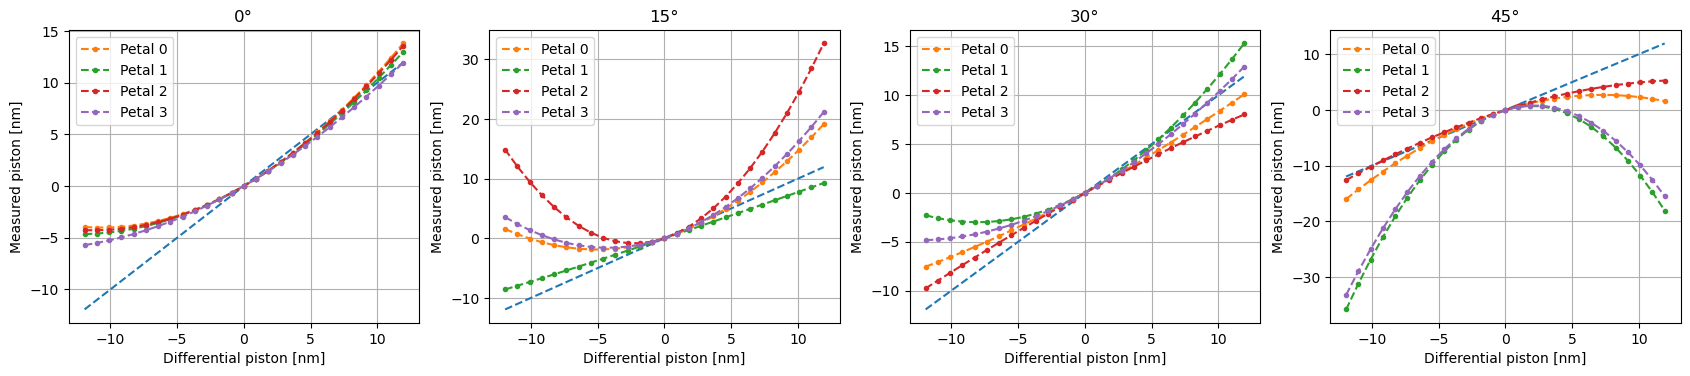

In [7]:
plot_petal_response([petals00,petals15,petals30,petals45], method='slopes', max_amp=0.1, title_str_list=['0°','15°','30°','45°'])

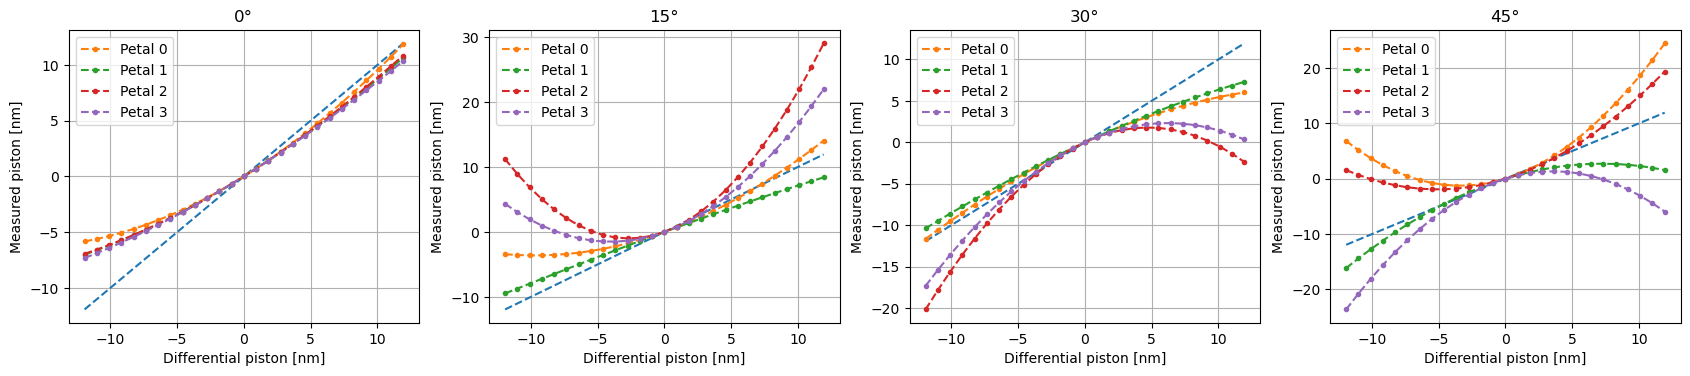

In [8]:
plot_petal_response([petals00,petals15,petals30,petals45], method='diagonal_slopes', max_amp=0.1, title_str_list=['0°','15°','30°','45°'])

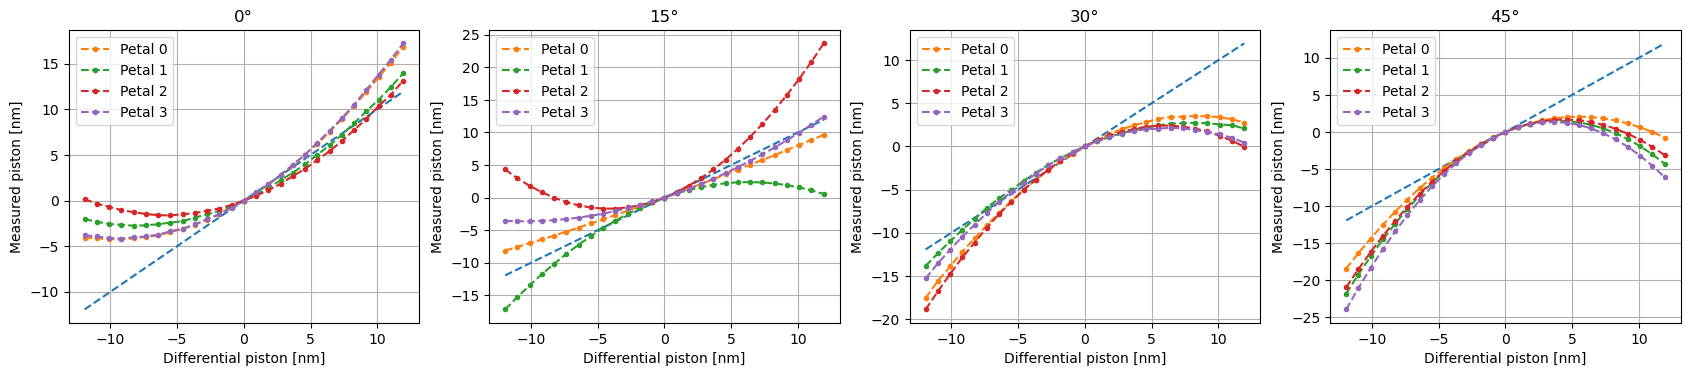

In [9]:
plot_petal_response([petals00,petals15,petals30,petals45], method='raw_intensity', max_amp=0.1, title_str_list=['0°','15°','30°','45°'])

Modulating 0 [lambda/D] with 0 modulation steps


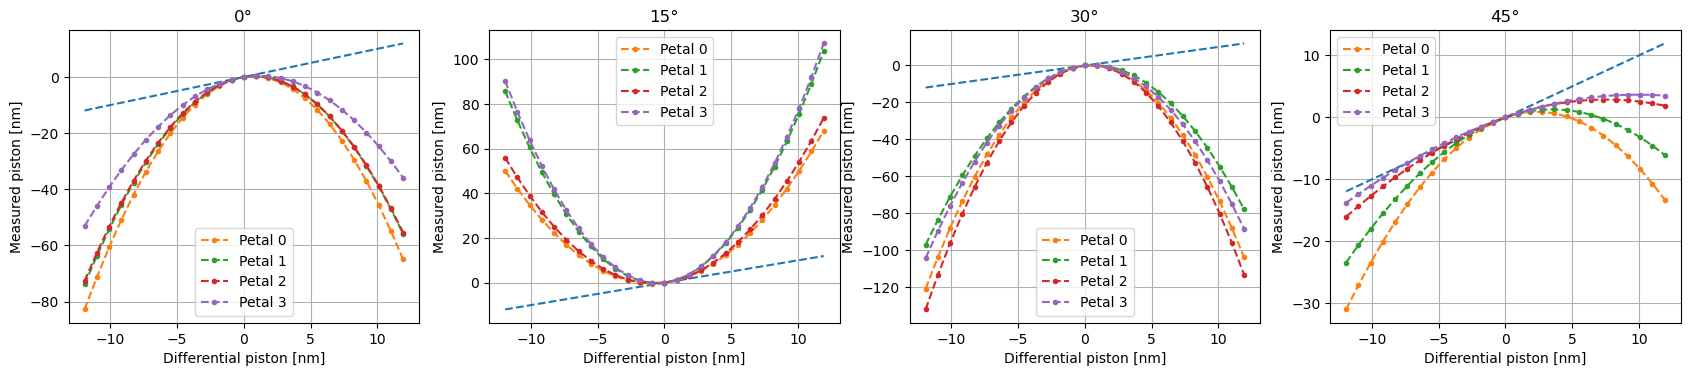

In [10]:
wfs.set_modulation_angle(0.0)
plot_petal_response([petals00,petals15,petals30,petals45], method='slopes', max_amp=0.1, calib_amp=1e-4, title_str_list=['0°','15°','30°','45°'])

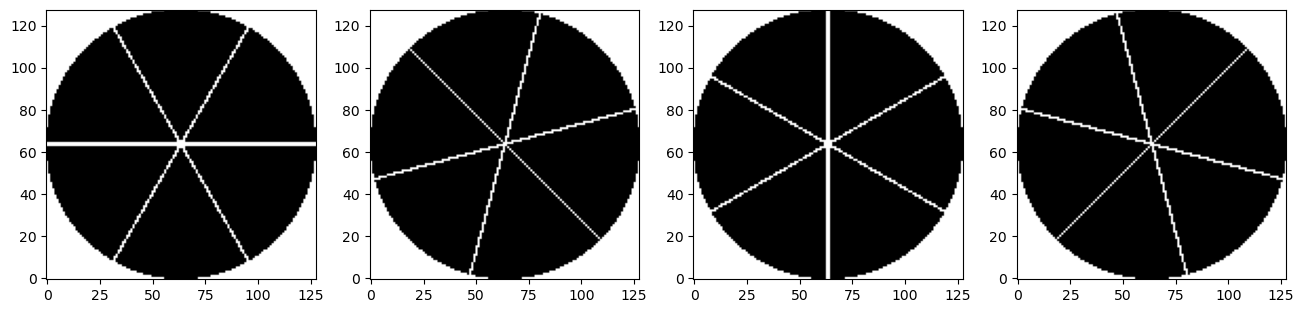

In [11]:
# 6 spiders
anglesInDeg = xp.array([0.,60.,120.,180.,240.,300.])

aperture00, petals00 = mask_with_spiders(cmask, widthInM*m2pix, anglesInDeg*deg2rad)
aperture15, petals15 = mask_with_spiders(cmask, widthInM*m2pix, (anglesInDeg+15.)*deg2rad)
aperture30, petals30 = mask_with_spiders(cmask, widthInM*m2pix, (anglesInDeg+30.)*deg2rad)
aperture45, petals45 = mask_with_spiders(cmask, widthInM*m2pix, (anglesInDeg+45.)*deg2rad)

plt.figure(figsize=(16,3.5))
plt.subplot(1,4,1)
plt.imshow(xp.asnumpy(aperture00),origin='lower',cmap='gray')
plt.subplot(1,4,2)
plt.imshow(xp.asnumpy(aperture15),origin='lower',cmap='gray')
plt.subplot(1,4,3)
plt.imshow(xp.asnumpy(aperture30),origin='lower',cmap='gray')
plt.subplot(1,4,4)
plt.imshow(xp.asnumpy(aperture45),origin='lower',cmap='gray')

(128, 128) (128, 128) (128, 128) (128, 128)


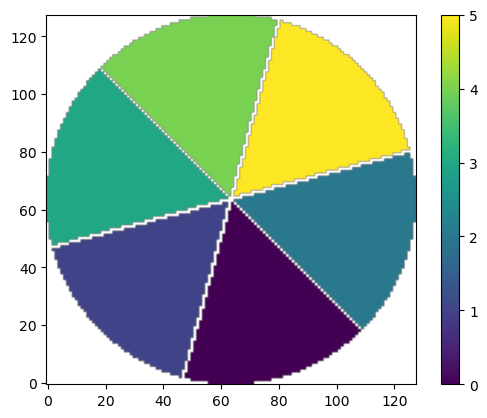

In [12]:
print(petals45.shape,petals00.shape,petals30.shape,petals15.shape)

plt.figure()
plt.imshow(masked_array(xp.asnumpy(petals15),mask=xp.asnumpy(aperture15)),origin='lower')
plt.colorbar()

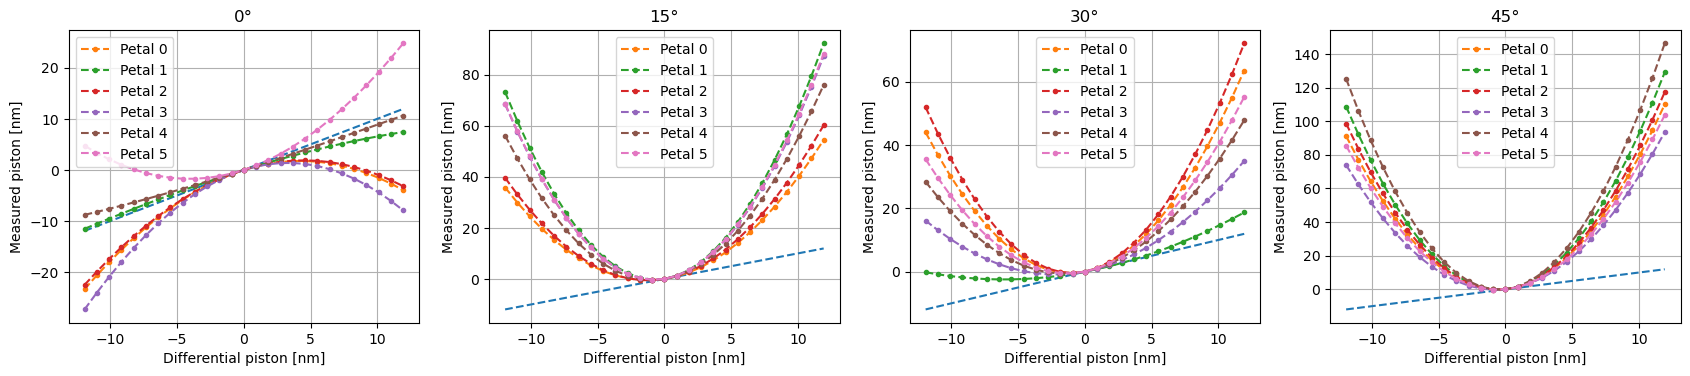

In [13]:
plot_petal_response([petals00,petals15,petals30,petals45], method='slopes', max_amp=0.1, calib_amp=1e-4, title_str_list=['0°','15°','30°','45°'])

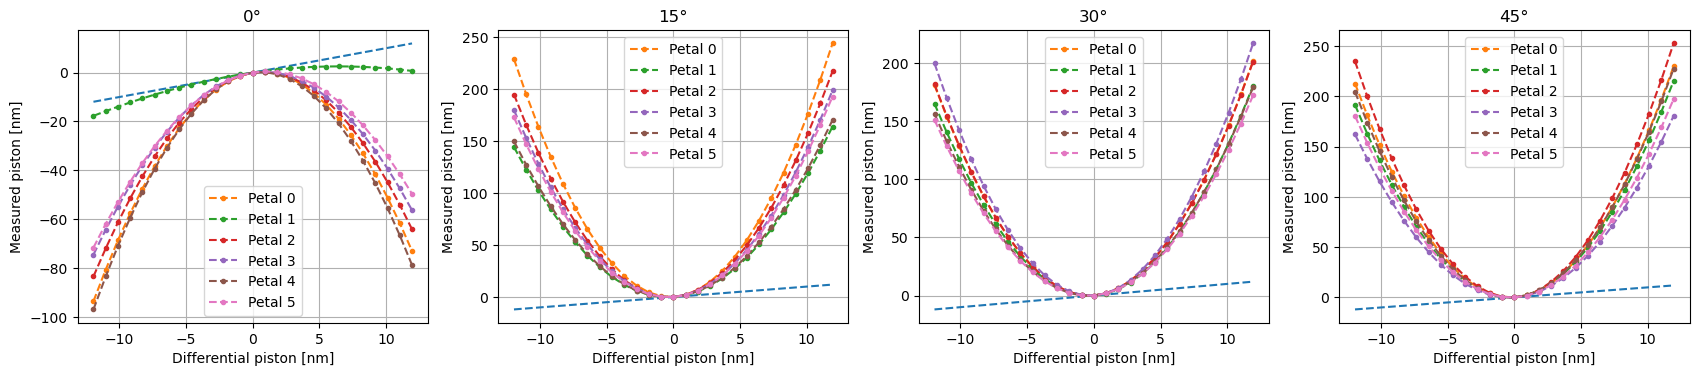

In [14]:
plot_petal_response([petals00,petals15,petals30,petals45], method='raw_intensity', max_amp=0.1, calib_amp=1e-4, title_str_list=['0°','15°','30°','45°'])